   orientation  station  subjective_distance
0            1        1                    5
1            1        1                    4
2            1        1                    3
3            1        1                    3
4            1        1                    4

researchpy summary statistics:


                      N      Mean        SD        SE  95% Conf.  Interval
orientation station                                                       
1           1        26  3.653846  1.093336  0.214421   3.233581  4.074111
            2        26  2.769231  1.031802  0.202353   2.372619  3.165843
            3        23  1.608696  0.722315  0.150613   1.313494  1.903897
            4        26  2.769231  1.142198  0.224003   2.330184  3.208277
2           1        25  2.640000  0.994987  0.198997   2.249965  3.030035
            2        25  1.640000  0.810350  0.162070   1.322343  1.957657
            3        26  2.192308  1.233507  0.241911   1.718163  2.666452
            4        

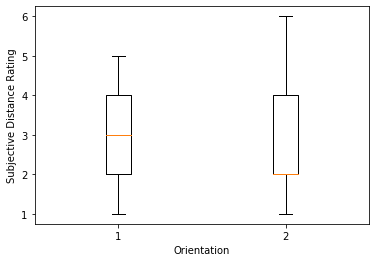

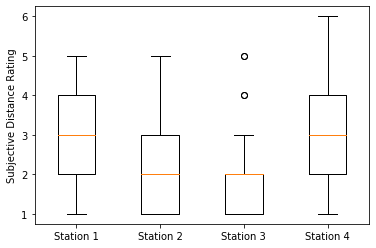

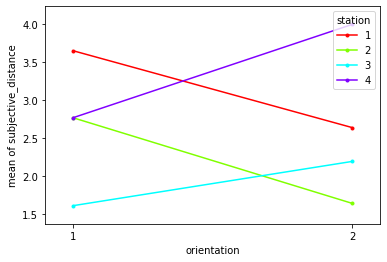

In [14]:
import pandas as pd
import numpy as np
import statistics
import random
import scipy
from scipy import stats
import researchpy as rp
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp
from statsmodels.graphics.factorplots import interaction_plot


import requests
from io import StringIO

# getting Maglio and Polman's data. 
# original paper: https://journals.sagepub.com/stoken/default+domain/hv65WpzIjfXtVjXCbJw6/full
# link to csv obtained from https://sites.trinity.edu/osl/data-sets-and-activities/factorial-anova-activities

url='https://drive.google.com/file/d/0Bz-rhZ21ShvOREt3S1BrZDM5Sk0/view'

url = url.split('/')[-2]

dwn_url ='https://drive.google.com/uc?export=download&id=' + url

url = requests.get(dwn_url).text

csv = StringIO(url)

dframe = pd.read_csv(csv)

dframe.columns = ['direction', 'orientation', 'station', 'subjective_distance']

dframe = dframe[['orientation', 'station', 'subjective_distance']]

print(dframe.head())

subjective_distance = dframe['subjective_distance']

orientation_1 = dframe[dframe.orientation == 1]['subjective_distance'] 
orientation_2 = dframe[dframe.orientation == 2]['subjective_distance'] 

station_1 = dframe[dframe.station == 1]['subjective_distance']
station_2 = dframe[dframe.station == 2]['subjective_distance']
station_3 = dframe[dframe.station == 3]['subjective_distance']
station_4 = dframe[dframe.station == 4]['subjective_distance']

# using researchpy to generate summary statistics

print()
print('researchpy summary statistics:')

print(rp.summary_cont(dframe.groupby(['orientation', 'station']))['subjective_distance'])

# using statsmodels to fit a model that includes main effects of orientation and station
# the model also includes an interaction term

model = ols('subjective_distance ~ C(orientation)*C(station)', dframe).fit()

print()
print('statsmodels ANOVA results:')
print()
print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .4f}")
print()
model.summary()

result = sm.stats.anova_lm(model, typ= 2)
print(result)
print()
        
# manually calculating 2x4 ANOVA

# calculating the sum of squares for orientation
    
g = sum(subjective_distance)    
N = len(subjective_distance)

SS_orientation = (sum(orientation_1)**2/len(orientation_1) + sum(orientation_2)**2/len(orientation_2))  - g**2/N

# calculating the sum of squares for station

SS_station = (sum(station_1)**2/len(station_1) + sum(station_2)**2/len(station_2) + sum(station_3)**2/len(station_3) + sum(station_4)**2/len(station_4)) - g**2/N

no_orientation_levels = len([orientation_1, orientation_2])
no_station_levels = len([station_1,station_2, station_3, station_4])

df_orientation = no_orientation_levels-1
df_station = no_station_levels - 1

# calculating the between treatments sum of squares

orientation_1_data = dframe[dframe['orientation'] == 1]
orientation_2_data = dframe[dframe['orientation'] == 2]

treatment1 = orientation_1_data[orientation_1_data['station'] == 1]['subjective_distance']
treatment2 = orientation_1_data[orientation_1_data['station'] == 2]['subjective_distance']
treatment3 = orientation_1_data[orientation_1_data['station'] == 3]['subjective_distance']
treatment4 = orientation_1_data[orientation_1_data['station'] == 4]['subjective_distance']

treatment5 = orientation_2_data[orientation_2_data['station'] == 1]['subjective_distance']
treatment6 = orientation_2_data[orientation_2_data['station'] == 2]['subjective_distance']
treatment7 = orientation_2_data[orientation_2_data['station'] == 3]['subjective_distance']
treatment8 = orientation_2_data[orientation_2_data['station'] == 4]['subjective_distance']

sum_t1_sq_ov_nt = (sum(treatment1)**2)/len(treatment1)
sum_t2_sq_ov_nt = (sum(treatment2)**2)/len(treatment2)
sum_t3_sq_ov_nt = (sum(treatment3)**2)/len(treatment3)
sum_t4_sq_ov_nt = (sum(treatment4)**2)/len(treatment4)
sum_t5_sq_ov_nt = (sum(treatment5)**2)/len(treatment5)
sum_t6_sq_ov_nt = (sum(treatment6)**2)/len(treatment6)
sum_t7_sq_ov_nt = (sum(treatment7)**2)/len(treatment7)
sum_t8_sq_ov_nt = (sum(treatment8)**2)/len(treatment8)

SS_between_treatments = (sum_t1_sq_ov_nt + sum_t2_sq_ov_nt + sum_t3_sq_ov_nt + sum_t4_sq_ov_nt + sum_t5_sq_ov_nt + sum_t6_sq_ov_nt + sum_t7_sq_ov_nt + sum_t8_sq_ov_nt) - g**2/N

df_between_treatments = len([treatment1, treatment2, treatment3, treatment4, treatment5, treatment6, treatment7, treatment8])-1

# calulating the interaction sum of squares

SS_interaction = SS_between_treatments - SS_orientation - SS_station

df_interaction = df_between_treatments - df_orientation - df_station

# calculating the within treatments sum of squares

sum_x_sq_t1 = []
for i in treatment1:
    sum_x_sq_t1.append(i**2)
    
sum_x_sq_t1 = sum(sum_x_sq_t1)

sum_x_sq_t2 = []
for i in treatment2:
    sum_x_sq_t2.append(i**2)
    
sum_x_sq_t2 = sum(sum_x_sq_t2)

sum_x_sq_t3 = []
for i in treatment3:
    sum_x_sq_t3.append(i**2)
    
sum_x_sq_t3 = sum(sum_x_sq_t3)

sum_x_sq_t4 = []
for i in treatment4:
    sum_x_sq_t4.append(i**2)
    
sum_x_sq_t4 = sum(sum_x_sq_t4)

sum_x_sq_t5 = []
for i in treatment5:
    sum_x_sq_t5.append(i**2)

sum_x_sq_t5 = sum(sum_x_sq_t5)

sum_x_sq_t6 = []
for i in treatment6:
    sum_x_sq_t6.append(i**2)
    
sum_x_sq_t6 = sum(sum_x_sq_t6)

sum_x_sq_t7 = []
for i in treatment7:
    sum_x_sq_t7.append(i**2)
    
sum_x_sq_t7 = sum(sum_x_sq_t7)

sum_x_sq_t8 = []
for i in treatment8:
    sum_x_sq_t8.append(i**2)
    
sum_x_sq_t8 = sum(sum_x_sq_t8)

ss_t1 = sum_x_sq_t1 - sum(treatment1)**2/len(treatment1)
ss_t2 = sum_x_sq_t2 - sum(treatment2)**2/len(treatment2)
ss_t3 = sum_x_sq_t3 - sum(treatment3)**2/len(treatment3)
ss_t4 = sum_x_sq_t4  - sum(treatment4)**2/len(treatment4)
ss_t5 = sum_x_sq_t5  - sum(treatment5)**2/len(treatment5)
ss_t6 = sum_x_sq_t6 - sum(treatment6)**2/len(treatment6)
ss_t7 = sum_x_sq_t7  - sum(treatment7)**2/len(treatment7)
ss_t8 = sum_x_sq_t8  - sum(treatment8)**2/len(treatment8)

SS_within_treatments = ss_t1 + ss_t2 + ss_t3 + ss_t4 + ss_t5 + ss_t6 + ss_t7 + ss_t8
                                                 
df_t1 = len(treatment1)-1
df_t2 = len(treatment2)-1
df_t3 = len(treatment3)-1
df_t4 = len(treatment4)-1
df_t5 = len(treatment5)-1
df_t6 = len(treatment6)-1
df_t7 = len(treatment7)-1
df_t8 = len(treatment8)-1

df_within_treatments = df_t1 + df_t2 + df_t3 + df_t4 + df_t5 + df_t6 + df_t7 + df_t8

# calculating the variance partitions

var_between_treatments = SS_between_treatments/df_between_treatments

var_within_treatments = SS_within_treatments/df_within_treatments

var_station = SS_station/df_station

var_orientation = SS_orientation/df_orientation

var_interaction = SS_interaction/df_interaction

# calculating the F-ratio

F_orientation = var_orientation/var_within_treatments

F_station = var_station/var_within_treatments

F_interaction = var_interaction/var_within_treatments

# printing manually calculated results

print()
print('Manually calculated F ratios:')
print('F Ratio for Orientation = ', F_orientation)
print('F Ratio for Station = ', F_station)
print('F Ratio for Interation = ', F_interaction)
print()

# reporting the significance of the main effects and interactions at the p = 0.05 alpha level

result_2 = result['PR(>F)']

if result_2[0] <= 0.05:
    print('There was a significant main effect of orientation. P =', round(result_2[0], 15))
if result_2[0] > 0.05:
        print('The was not a significant main effect of orientation. P =', round(result_2[0],15))
print()

if result_2[1] <= 0.05:
    print('There was a significant main effect of station. P =', round(result_2[1], 15))
if result_2[1] > 0.05:
        print('The was not a significant main effect of station. P =', round(result_2[1],15))
        
print()

if result_2[2] <= 0.05:
    print('There was a significant orientation*station interaction effect. P =', round(result_2[2],15))
if result_2[2] > 0.05:
        print('The was not a significant orientation*station interaction effect. P =', round(result_2[2],15))

# plotting the data

plt.boxplot([orientation_1, orientation_2])
plt.xlabel('Orientation')
plt.ylabel('Subjective Distance Rating')

plt.show()

plt.boxplot([station_1, station_2, station_3, station_4], labels = ['Station 1', 'Station 2', 'Station 3', 'Station 4'])
plt.ylabel('Subjective Distance Rating')
plt.show()

str_or = pd.Series(dframe['orientation'].astype(str))

fig = interaction_plot(str_or, dframe['station'], dframe['subjective_distance'])